## 

## Medical Image Segmentation and Applications (MISA)
## Brain tissue segmentation - IBSR18 PROJECT
Taiabur Rahman

Medical Imaging and Application (MAIA), Universitat de Girona.

Image sets- 

training images: 10 (with GT)

validation images: 5 (with GT)

testing images: 3 (NO GT)

In [1]:

import glob
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm
import tensorflow as tf

from keras.utils import normalize
from tensorflow.keras.models import load_model
from keras.metrics import MeanIoU


from utils.visualization import image_show_with_mask, image_show_only, boxplot
from utils.metrics import dice_score_per_class, hausdorff_distance_per_class, ravd_per_class
from utils.patches import extract_useful_patches

2024-01-14 12:07:42.517072: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-14 12:07:42.598220: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-14 12:07:42.598258: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-14 12:07:42.599977: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-14 12:07:42.611512: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `tf.keras` framework.


In [2]:

# Image size
SIZE_X = 128
SIZE_Y = 128
N_CLASSES = 4

# Training Images List
train_images = []
validation_images = []
test_images = []

# Mask/Label info as a list
train_masks = []
validation_masks = []

# Dataset path define
base_path = "TrainingValidationTestSets/"
# Training images path
train_img_path = os.path.join(base_path, "Training_Set")
# Validation images path 
validation_img_path = os.path.join(base_path, "Validation_Set")
# Test images path
test_img_path = os.path.join(base_path, "Test_Set")


In [3]:

# Load and preprocess the training data
train_images = []
train_masks = []
for directory_path in glob.glob(os.path.join(train_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            train_images.append(img_data)
        else:
            train_masks.append(img_data)

train_images = np.array(train_images)
train_masks = np.array(train_masks)

# Load and preprocess the validation data
validation_images = []
validation_masks = []
for directory_path in glob.glob(os.path.join(validation_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            validation_images.append(img_data)
        else:
            validation_masks.append(img_data)

validation_images = np.array(validation_images)
validation_masks = np.array(validation_masks)

# Load and preprocess the test data
test_images = []
for directory_path in glob.glob(os.path.join(test_img_path, "*")):
    for image_path in glob.glob(os.path.join(directory_path, "IBSR_*.nii.gz")):
        img_data = nib.load(image_path).get_fdata()
        if not image_path.endswith("_seg.nii.gz"):
            test_images.append(img_data)

test_images = np.array(test_images)

In [4]:
# Array shape
print("Training Images: ", train_images.shape)
print("Validation Images: ", validation_images.shape)
print("Test Images: ", test_images.shape)

print("Training Mask: ", train_masks.shape)
print("Validation Mask: ", validation_masks.shape)

Training Images:  (10, 256, 128, 256, 1)
Validation Images:  (5, 256, 128, 256, 1)
Test Images:  (3, 256, 128, 256, 1)
Training Mask:  (10, 256, 128, 256, 1)
Validation Mask:  (5, 256, 128, 256, 1)


In [19]:

# print("Validation Images")
# image_show_with_mask(validation_images,validation_masks)
# print("Test Images")
# image_show_only(test_images)

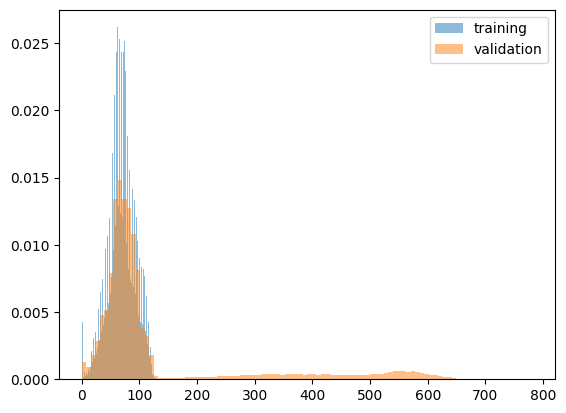

In [20]:
plt.hist(train_images[train_masks>0].flatten(), 100, label='training', alpha=0.5, density=True)
plt.hist(validation_images[validation_masks>0].flatten(), 100, label='validation', alpha=0.5, density=True)

plt.legend(loc='upper right')
plt.show()

In [21]:
PATCH_SIZE = (32, 32)
PATCH_STRIDE = (16, 16)
IMAGE_SIZE = (256, 128, 256)

N_INPUT_CHANNELS = 1
SCALING_FACTOR = 1

# data preparation parameters
CONTENT_THRESHOLD = 0.3

# training parameters
N_EPOCHS = 50
BATCH_SIZE = 32
PATIENCE = 10
MODEL_FOLDER = 'checkpoint'
OPTIMISER = 'Adam'
LOSS = 'categorical_crossentropy'
ACTIVATION='softmax'



In [22]:
from sklearn.model_selection import train_test_split

# Split the training data into training (80%) and validation (20%)
train_data, val_data, train_labels, val_labels = train_test_split(
    train_images, train_masks, test_size=0.2, random_state=42
)

In [23]:
patch_train_data, patch_train_label = extract_useful_patches(train_data, train_labels)
patch_val_data, patch_val_label = extract_useful_patches(val_data, val_labels)

In [24]:
# train and validation patch shape
print("Training : ", patch_train_data.shape)
print("Validation : ", patch_val_data.shape)

print("Training Mask: ", patch_train_label.shape)
print("Validation Mask: ", patch_val_label.shape)

Training :  (36201, 32, 32, 1)
Validation :  (14161, 32, 32, 1)
Training Mask:  (36201, 32, 32, 4)
Validation Mask:  (14161, 32, 32, 4)


In [26]:
from keras.utils import to_categorical

# train_masks_cat = to_categorical(patch_train_label, num_classes=N_CLASSES)
# y_train_cat = train_masks_cat.reshape((patch_train_label.shape[0], patch_train_label.shape[1], patch_train_label.shape[2], N_CLASSES))

# test_masks_cat = to_categorical(patch_val_label, num_classes=N_CLASSES)
# y_test_cat = test_masks_cat.reshape((patch_val_label.shape[0], patch_val_label.shape[1], patch_val_label.shape[2], N_CLASSES))

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]


In [31]:

dice_loss = sm.losses.DiceLoss(class_weights=np.array([0.25, 0.25, 0.25, 0.25])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

X_train1 = np.repeat(patch_train_data, 3, axis=-1)
X_test1 = np.repeat(patch_val_data, 3, axis=-1)


LR = 0.0001
optim = keras.optimizers.Adam(LR)

# Resnet34 Model 1
BACKBONE1 = 'resnet34'
preprocess_input1 = sm.get_preprocessing(BACKBONE1)

model1 = sm.Unet(BACKBONE1, encoder_weights='imagenet', classes=N_CLASSES, activation=ACTIVATION)
model1.compile(optim, total_loss, metrics=metrics)

# Train the model with the updated datasets
history1 = model1.fit(
    x=X_train1,
    y=patch_train_label,
    validation_data=(X_test1, patch_val_label),
    batch_size=8, 
    epochs=50,
    verbose=1,
)

model1.save('model/res34_backbone_50epochs.hdf5')


Epoch 1/50
4526/4526 [==============================] - 609s 130ms/step - loss: 0.8288 - iou_score: 0.7008 - f1-score: 0.7899 - val_loss: 0.8339 - val_iou_score: 0.7975 - val_f1-score: 0.8689
Epoch 2/50
4526/4526 [==============================] - 589s 130ms/step - loss: 0.8041 - iou_score: 0.7901 - f1-score: 0.8665 - val_loss: 0.8577 - val_iou_score: 0.7502 - val_f1-score: 0.8366
Epoch 3/50
4526/4526 [==============================] - 597s 132ms/step - loss: 0.7993 - iou_score: 0.8114 - f1-score: 0.8828 - val_loss: 0.8316 - val_iou_score: 0.8056 - val_f1-score: 0.8757
Epoch 4/50
4526/4526 [==============================] - 597s 132ms/step - loss: 0.7962 - iou_score: 0.8244 - f1-score: 0.8920 - val_loss: 0.8366 - val_iou_score: 0.7996 - val_f1-score: 0.8721
Epoch 5/50
4526/4526 [==============================] - 602s 133ms/step - loss: 0.7939 - iou_score: 0.8346 - f1-score: 0.8996 - val_loss: 0.8793 - val_iou_score: 0.7212 - val_f1-score: 0.8084
Epoch 6/50
4526/4526 [==================

/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
model1.save('model/res34_backbone_50epochs.keras')

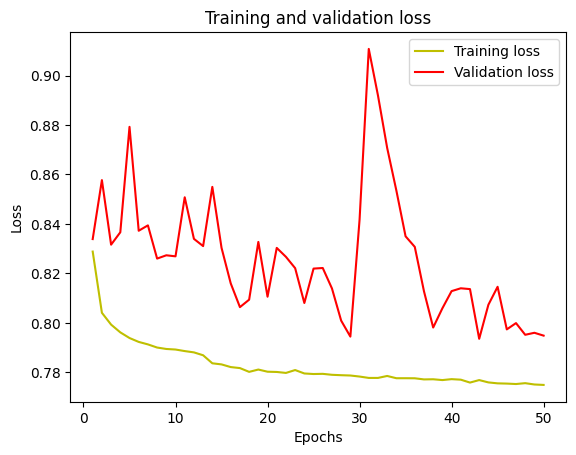

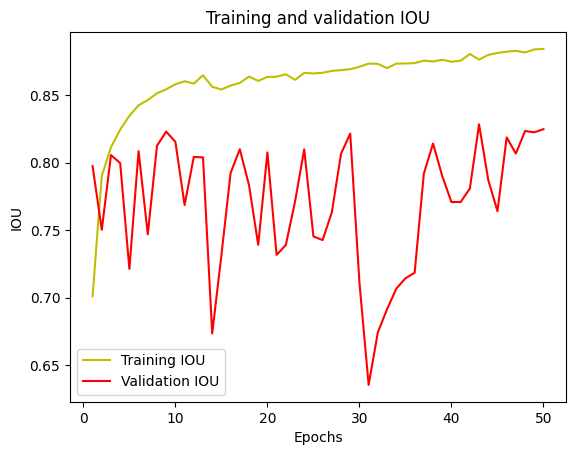

In [33]:
#plot the training and validation accuracy and loss at each epoch
loss = history1.history['loss']
val_loss = history1.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history1.history['iou_score']
val_acc = history1.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU')
plt.plot(epochs, val_acc, 'r', label='Validation IOU')
plt.title('Training and validation IOU')
plt.xlabel('Epochs')
plt.ylabel('IOU')
plt.legend()
plt.show()

In [4]:

model = load_model('model/res34_backbone_50epochs.keras')


2024-01-14 12:08:07.356510: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


TypeError: Unable to reconstruct an instance of 'SumOfLosses' because the class is missing a `from_config()` method. Full object config: {'module': 'segmentation_models.base.objects', 'class_name': 'SumOfLosses', 'config': 'dice_loss_plus_1focal_loss', 'registered_name': 'SumOfLosses'}

In [35]:
# Assuming validation_masks is your original array with shape (5, 256, 128, 256, 1)
validation_masks = np.array(validation_masks)
print(validation_images.shape)
# Remove the last dimension
validation_masks_squeezed = np.squeeze(validation_masks, axis=-1)

ds_score =[]
hd_score =[]
havd_score =[]

for i in range(5):
    prediction = model1.predict(x=validation_images[i,:,:,:,:])
    prediction = np.argmax(prediction, axis=3)

    gt_image = validation_masks_squeezed[i,:,:,:]

    ds_score.append(dice_score_per_class(prediction, gt_image))
    hd_score.append(hausdorff_distance_per_class(prediction, gt_image))
    havd_score.append(ravd_per_class(prediction, gt_image))
    print("Image: ",i)


(5, 256, 128, 256, 1)


ValueError: in user code:

    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/training.py", line 2381, in predict_step
        return self(x, training=False)
    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/cad04/MISA/.venv/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model_8' (type Functional).
    
    Input 0 of layer "bn_data" is incompatible with the layer: expected axis 3 of input shape to have value 3, but received input with shape (32, 128, 256, 1)
    
    Call arguments received by layer 'model_8' (type Functional):
      • inputs=tf.Tensor(shape=(32, 128, 256, 1), dtype=float32)
      • training=False
      • mask=None
